In [2]:
from utils.molec_class_files import r14, r32, r50, r125, r134a, r143a, r170, r41, r23, r161, r152a, r152, r134, r143, r116
from utils import atom_type, opt_atom_types
import numpy as np
import unyt as u
import pandas as pd
from fffit.fffit.utils import values_real_to_scaled, values_scaled_to_real, variances_scaled_to_real, generate_lhs
from fffit.fffit.plot import plot_obj_contour
import os

2024-07-09 15:43:03.673086: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 15:43:03.714612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 15:43:03.714655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 15:43:03.715919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 15:43:03.722853: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 15:43:03.723775: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [8]:
#Load in molecgp_data R32 vap gp from pkl file
molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a"]
molecgp_data = opt_atom_types.get_gp_data_from_pkl(molec_names)
model = molecgp_data["R32"]['sim_Pvap']
hyperparameters = {
        'Mean Fxn A': model.mean_function.A.numpy(),
        'Mean Fxn B': model.mean_function.b.numpy(),
        'kernel_variance': model.kernel.variance.numpy(),
        'kernel_lengthscale': model.kernel.lengthscales.numpy(),
        'likelihood_variance': model.likelihood.variance.numpy()
    }
print(hyperparameters)

{'Mean Fxn A': array([[ 0.11760296],
       [ 0.76195969],
       [ 0.32789815],
       [-1.25374516],
       [-0.86652762],
       [-0.31504035],
       [ 2.13644455]]), 'Mean Fxn B': array([1.78430406]), 'kernel_variance': array(0.7279655), 'kernel_lengthscale': array([0.58276322, 0.51638163, 1.32746616, 1.18839275, 1.72149136,
       3.66785886, 0.91923148]), 'likelihood_variance': array(4.35747547e-05)}


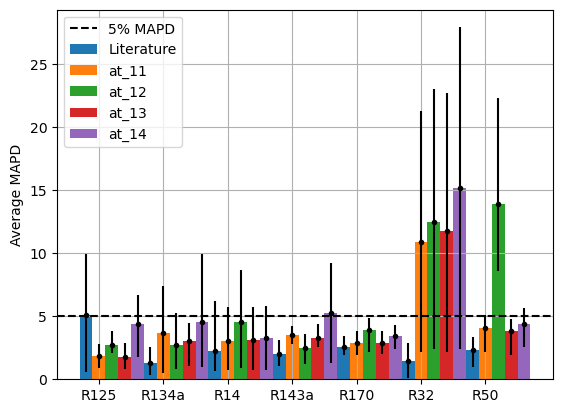

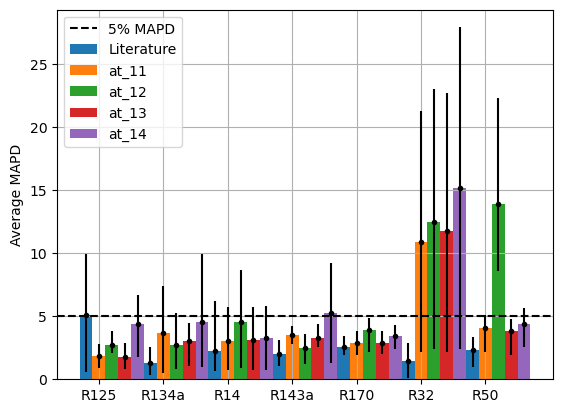

In [2]:
#Imports
from utils.molec_class_files import r14, r32, r50, r125, r134a, r143a, r170
from utils import atom_type, opt_atom_types
import numpy as np
import unyt as u
import pandas as pd
import os
import copy
import scipy 
import signac
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#Set params for what you want to analyze
save_data = False #Data to save
obj_choice = "ExpVal" #Objective to consider
at_number = 11 #atom type to consider
seed = 1 #Seed to use
molec_names = ["R14", "R32", "R50", "R170", "R125", "R134a", "R143a"] #Training data to consider

#Get best_run data saved in one csv from all jobs
project = signac.get_project("opt_at_params")
#Create visualization object
visual = opt_atom_types.Vis_Results(molec_names, at_number, seed, obj_choice)
#Set parameter set of interest (in this case get the best parameter set)
all_molec_dir = visual.use_dir_name
path_best_sets = os.path.join(all_molec_dir, "best_per_run.csv")
assert os.path.exists(path_best_sets), "best_per_run.csv not found in directory"
all_df = pd.read_csv(path_best_sets, header = 0)
first_param_name = visual.at_class.at_names[0] + "_min"
last_param_name = visual.at_class.at_names[-1] + "_min"
best_set = all_df.loc[0, first_param_name:last_param_name].values
# path_best_sets = os.path.join(all_molec_dir, "opt_params_rcc_best_set_1.csv")
# assert os.path.exists(path_best_sets), "opt_params_rcc_best_set_1.csv not found in directory"
# all_df = pd.read_csv(path_best_sets, header = 0)
# best_set = all_df.loc[:, visual.at_class.at_names].values
best_real = visual.values_pref_to_real(copy.copy(best_set))
x_label = "best_set"


#Plot atom_type scheme results
at_schemes = [11,12,13,14]
obj_choices = ["ExpVal", "ExpValPrior"]
labels = ["best_set", "best_set_1"]
if len(at_schemes) > 1 and isinstance(at_schemes, (list,np.ndarray)):
    at_schemes.sort()
    sort_str_list = [str(element) for element in at_schemes]
    at_str = '-'.join(sort_str_list)
else:
    at_str = at_schemes[0]
# pdf = PdfPages('Results/at_schemes_' + at_str + '.pdf')
# visual.plot_obj_MSE(molec_names, obj_choices, labels)
visual.plot_at_MSE(molec_names, at_schemes)
#Close figures 
# plt.close()
# pdf.close()   

In [ ]:
import scipy 
import os
repeats = 1
seed = 1
#Get obj from a set of parameters
at_class = 11
save_data = False
obj_choice = "ExpVal"
obj_choice_p = "ExpValPrior"
molec_names = ["R14", "R32", "R50", "R125", "R134a", "R143a", "R170"]
at_optimizer =  opt_atom_types.Opt_ATs(molec_names, at_class, repeats, seed, obj_choice_p)
# visual = opt_atom_types.Vis_Results(molec_data_dict, all_gp_dict, at_class, obj_choice)
# visual.check_GPs()
setup = opt_atom_types.Problem_Setup(molec_names, at_class, obj_choice)
all_molec_dir = setup.use_dir_name
all_df = pd.read_csv(all_molec_dir /"best_per_run.csv", header = 0)
sorted_df = all_df.sort_values(by='Min Obj', ascending = True).reset_index(drop = True)
first_param_name = setup.at_class.at_names[0] + "_min"
last_param_name = setup.at_class.at_names[-1] + "_min"
best_pref = all_df.loc[0, first_param_name:last_param_name].values
best_real= at_optimizer.values_pref_to_real(best_pref)
# best_real = generate_lhs(1, at_optimizer.at_class.at_bounds_nm_kjmol, at_optimizer.seed, labels = None)
obj = at_optimizer.calc_obj(best_real)
print(obj[0])

# #Get Jac and Hess info from a set of parameters
# dir_name = at_optimizer.make_results_dir(list(at_optimizer.molec_data_dict.keys()))
# save_path = os.path.join(dir_name, "best_set" + "_jac_approx.npy")
# hess = np.load(save_path)
# print(hess)
# jac = at_optimizer.approx_jac(best_real)
# hess = at_optimizer.approx_hess(best_real)
# print(scipy.linalg.norm(jac, ord = np.inf))
# print(jac)
# print(hess)
# eigval, eigvec = scipy.linalg.eig(hess)
# print(eigval)